# Entregable 3 de Optimización Determinista

## Integrantes:
- A01066843 - Facundo Bautista Barbera
- A01742811 - Valeria Garcia Hernandez
- A01285034 - Ana Sofia Nagao Alvarez
-  A01424351 - Azul Fernanda Paniagua Bucio
- A01424357 - Patricio Mourra Cossío

# Cargar Librerías

In [17]:
import json
import math
import os
import xml.etree.ElementTree as ET
import zipfile

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Cargar Datos

Para empezar el proceso de prueba, se necesitan cargar los puntos del mapa.
Este mapa se ha hecho en un software llamado GeoGebra, y se ha exportado a un archivo .ggb.
A continuación se extraerán los puntos del archivo .ggb y se guardarán en un archivo .csv.

_Nota: Si los archivos ya existen, no se volverán a crear._

In [18]:
INPUT_GGB = "data/raw/puntos.ggb"
DICTIONARY_JSON = "data/raw/dictionary.json"
OUTPUT_CSV = "data/processed/puntos.csv"
SCALED_CSV = "data/processed/puntos_escalados.csv"


def extract_points_from_ggb(ggb_file):
    """Extract point coordinates from a GeoGebra .ggb file."""
    points_dict = {}

    with zipfile.ZipFile(ggb_file, "r") as zip_ref:
        with zip_ref.open('geogebra.xml') as file:
            tree = ET.parse(file)
            root = tree.getroot()

            for element in root.iter('element'):
                if element.attrib.get('type') == 'point':
                    label = element.attrib.get('label', None)
                    coords = element.find('coords')
                    if label and coords is not None:
                        try:
                            x = float(coords.attrib.get('x', 'nan'))
                            y = float(coords.attrib.get('y', 'nan'))
                            points_dict[label] = (x, y)
                        except ValueError:
                            pass

    return points_dict


def rename_points(points_dict, dictionary_file):
    """Rename point labels based on dictionary.json using the 'nombre' field."""
    with open(dictionary_file, 'r') as f:
        rename_dict = json.load(f)

    # Create reverse mapping using the 'nombre' field from each dictionary entry
    reversed_dict = {value["nombre"]: key for key, value in rename_dict.items() if "nombre" in value}

    renamed_points = {reversed_dict.get(label, label): coords for label, coords in points_dict.items()}

    return renamed_points


def save_to_csv(points_dict, output_file):
    """Save points to CSV."""
    df = pd.DataFrame(points_dict.items(), columns=['Label', 'Coordinates'])
    df[['X', 'Y']] = pd.DataFrame(df['Coordinates'].tolist(), index=df.index)
    df = df.drop(columns=['Coordinates'])

    df.to_csv(output_file, index=False)
    print(f"Saved points to {output_file}")


def scale_points(points_dict, target_distance=100):
    """Scale points so that the distance between C and D is exactly target_distance and remove A, B, C, and D."""
    if 'C' not in points_dict or 'D' not in points_dict:
        raise ValueError("Points 'C' and 'D' must be present in the dataset for scaling.")

    xC, yC = points_dict['C']
    xD, yD = points_dict['D']
    current_distance = math.dist((xC, yC), (xD, yD))

    scale_factor = target_distance / current_distance

    # Find midpoint of C and D for scaling reference
    mid_x = (xC + xD) / 2.0
    mid_y = (yC + yD) / 2.0

    scaled_points = {}
    for label, (x, y) in points_dict.items():
        x_scaled = ((x - mid_x) * scale_factor) + mid_x
        y_scaled = ((y - mid_y) * scale_factor) + mid_y
        scaled_points[label] = (x_scaled, y_scaled)

    # Remove points A, B, C, and D
    for point in ['A', 'B', 'C', 'D']:
        scaled_points.pop(point, None)

    return scaled_points


# Step 1: Extract points from GGB
points = extract_points_from_ggb(INPUT_GGB)

# Step 2: Rename points based on dictionary.json
renamed_points = rename_points(points, DICTIONARY_JSON)

# Step 3: Save renamed points to puntos.csv
save_to_csv(renamed_points, OUTPUT_CSV)

# Step 4: Scale points and save to puntos_escalados.csv
scaled_points = scale_points(renamed_points)
save_to_csv(scaled_points, SCALED_CSV)

Saved points to data/processed/puntos.csv
Saved points to data/processed/puntos_escalados.csv


# Graficar Puntos

A continuación se graficarán los puntos extraídos del archivo .ggb.

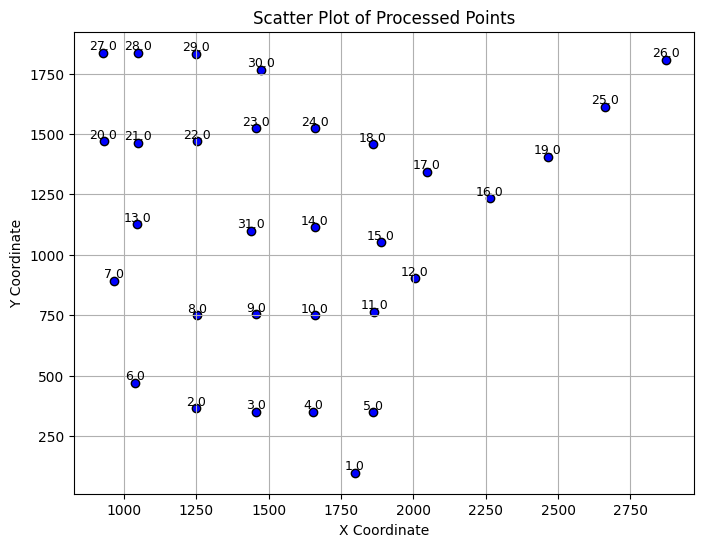

In [19]:
def plot_points(csv_file):
    df = pd.read_csv(csv_file)

    if not {'Label', 'X', 'Y'}.issubset(df.columns):
        raise ValueError("The CSV file must contain 'Label', 'X', and 'Y' columns.")

    plt.figure(figsize=(8, 6))
    plt.scatter(df["X"], df["Y"], color='blue', edgecolors='black')

    for _, row in df.iterrows():
        plt.text(row["X"], row["Y"], row["Label"], fontsize=9, ha='center', va='bottom')

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Scatter Plot of Processed Points")
    plt.grid(True)
    plt.show()


plot_points("data/processed/puntos_escalados.csv")  # Use puntos.csv instead of puntos_escalados.csv

# Obtener Distancias entre Puntos

A continuación se calcularán las distancias entre los puntos y se guardarán en un archivo .csv.

In [20]:
def compute_distances(csv_file):
    df = pd.read_csv(csv_file)

    if not {'Label', 'X', 'Y'}.issubset(df.columns):
        raise ValueError("El archivo CSV debe contener las columnas 'Label', 'X' y 'Y'.")

    labels = df["Label"].values
    coords = df[["X", "Y"]].values
    num_points = len(labels)

    distance_matrix = pd.DataFrame(index=labels, columns=labels, dtype=float)

    for i in range(num_points):
        for j in range(num_points):
            # math.dist() retorna la distancia en la misma unidad que las coordenadas (metros).
            # Para convertir a km, dividimos entre 1000.
            distance_matrix.iloc[i, j] = math.dist(coords[i], coords[j]) / 1000.0

    distance_matrix.to_csv("data/processed/matriz_distancias.csv")
    return distance_matrix

distances = compute_distances("data/processed/puntos_escalados.csv")

# Crear grafo de distancias

A continuación se creará un grafo con las distancias entre los puntos.

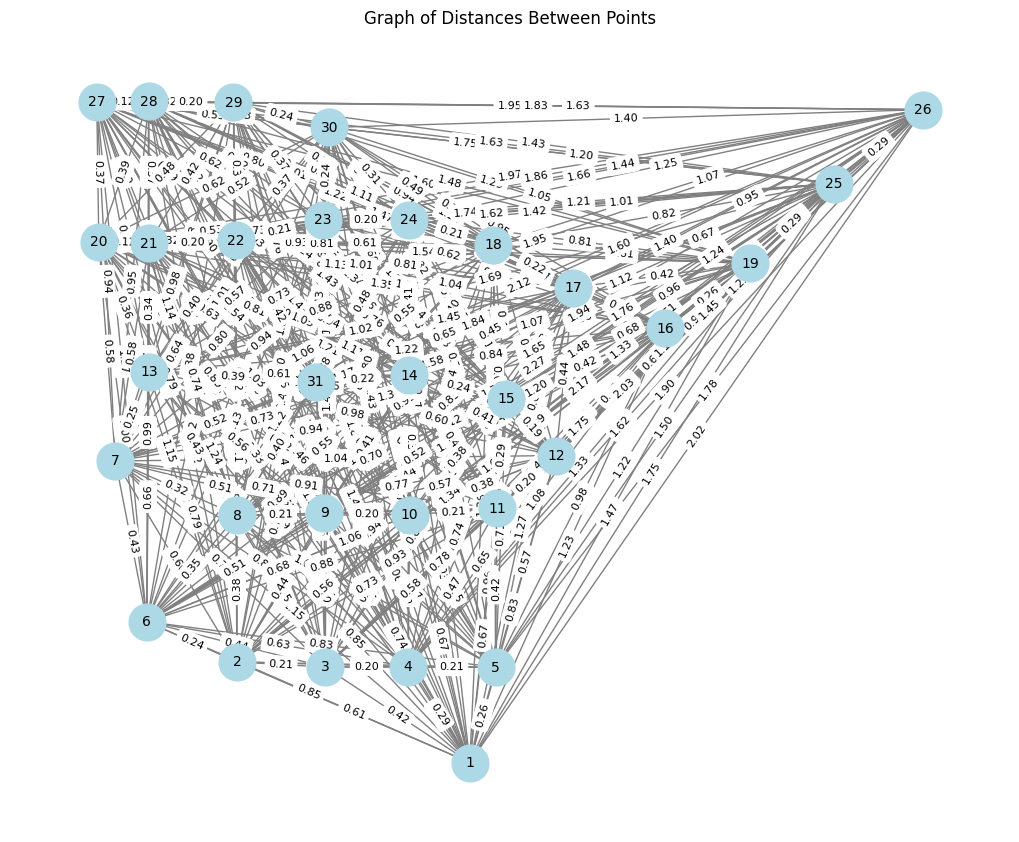

In [21]:
def plot_distance_graph(csv_file):
    df_distances = pd.read_csv(csv_file, index_col=0)
    # Ensure that the index and columns are of string type
    df_distances.index = df_distances.index.astype(str)
    df_distances.columns = df_distances.columns.astype(str)

    # Ahora trabajamos directamente con las distancias sin convertir a km.
    G = nx.Graph()

    labels = df_distances.index
    for label in labels:
        G.add_node(label)

    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            if i < j:
                distance = df_distances.iloc[i, j]
                G.add_edge(label1, label2, weight=distance)

    # Ajustar la posición de los nodos
    pos = {node: (-x, y) for node, (x, y) in nx.kamada_kawai_layout(G).items()}

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)

    edge_labels = {(label1, label2): f"{df_distances.loc[label1, label2]:.2f}"
                   for label1, label2 in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Graph of Distances Between Points")
    plt.show()

# Ejecución de la función
plot_distance_graph("data/processed/matriz_distancias.csv")

# Crear polígonos

A continuación se creará un polígono con los puntos extraídos del archivo .ggb.

Se crearan:
- 5 polígonos con 15 nodos aleatorios (small)
- 5 polígonos con 20 nodos aleatorios (medium)
- 5 polígonos con 25 nodos aleatorios (large)

Los polígonos son guardados en archivos .csv.

In [22]:
def generate_random_clusters(csv_file, cluster_size, num_variations):
    df = pd.read_csv(csv_file)

    # Asegurar que el nodo 18 siempre se incluya
    mandatory_node = df[df['Label'].astype(str) == '18']
    df = df[df['Label'].astype(str) != '18']

    if not {'Label', 'X', 'Y'}.issubset(df.columns):
        raise ValueError("The CSV file debe contener 'Label', 'X', y 'Y'.")

    clusters = []
    for _ in range(num_variations):
        sampled_df = df.sample(n=cluster_size - 1, replace=False)  # -1 porque incluimos nodo 18
        sampled_df = pd.concat([sampled_df, mandatory_node])  # Agregar nodo 18
        clusters.append(sampled_df)

    return clusters


def save_clusters_to_csv(clusters, output_dir, prefix):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, cluster in enumerate(clusters):
        output_file_nodes = f"{output_dir}/{prefix}_nodes_{i + 1}.csv"
        output_file_matrix = f"{output_dir}/{prefix}_matrix_{i + 1}.csv"

        # Guardar nodos
        cluster.to_csv(output_file_nodes, index=False)

        # Calcular la matriz de distancia
        labels = cluster["Label"].values
        coords = cluster[["X", "Y"]].values
        num_points = len(labels)

        distance_matrix = pd.DataFrame(index=labels, columns=labels)
        for i in range(num_points):
            for j in range(num_points):
                distance_matrix.iloc[i, j] = math.dist(coords[i], coords[j]) / 1000

        distance_matrix.to_csv(output_file_matrix)

        print(f"Saved: {output_file_nodes}")
        print(f"Saved: {output_file_matrix}")


# Generar y guardar clusters
small_clusters = generate_random_clusters("data/processed/puntos_escalados.csv", 15, 5)
save_clusters_to_csv(small_clusters, "data/processed/small", "small")

medium_clusters = generate_random_clusters("data/processed/puntos_escalados.csv", 20, 5)
save_clusters_to_csv(medium_clusters, "data/processed/medium", "medium")

large_clusters = generate_random_clusters("data/processed/puntos_escalados.csv", 25, 5)
save_clusters_to_csv(large_clusters, "data/processed/big", "big")

Saved: data/processed/small/small_nodes_1.csv
Saved: data/processed/small/small_matrix_1.csv
Saved: data/processed/small/small_nodes_2.csv
Saved: data/processed/small/small_matrix_2.csv
Saved: data/processed/small/small_nodes_3.csv
Saved: data/processed/small/small_matrix_3.csv
Saved: data/processed/small/small_nodes_4.csv
Saved: data/processed/small/small_matrix_4.csv
Saved: data/processed/small/small_nodes_5.csv
Saved: data/processed/small/small_matrix_5.csv
Saved: data/processed/medium/medium_nodes_1.csv
Saved: data/processed/medium/medium_matrix_1.csv
Saved: data/processed/medium/medium_nodes_2.csv
Saved: data/processed/medium/medium_matrix_2.csv
Saved: data/processed/medium/medium_nodes_3.csv
Saved: data/processed/medium/medium_matrix_3.csv
Saved: data/processed/medium/medium_nodes_4.csv
Saved: data/processed/medium/medium_matrix_4.csv
Saved: data/processed/medium/medium_nodes_5.csv
Saved: data/processed/medium/medium_matrix_5.csv
Saved: data/processed/big/big_nodes_1.csv
Saved: d

# Resolver capacidades de los nodos

Un dato importante es determinar la capacidad de los nodos.
En el diccionario de los puntos, se incluye una variable "capacidad", la cual se utilizará para determinar la capacidad de los nodos con base en sus hectareas.

In [23]:
import json
import pandas as pd

def compute_nodos_capacidad(dictionary_json, output_nodes_csv):
    # Cargar los archivos JSON
    with open(dictionary_json, "r") as f:
        nodos_data = json.load(f)

    with open("data/raw/plantas.json", "r") as f:
        plantas_data = json.load(f)

    # Calcular la cantidad de plantas por nodo, multiplicando directamente
    # la capacidad del nodo por la "cantidad por hectarea"
    nodos_plantas_numerados = {}
    for nodo_id, nodo in nodos_data.items():
        capacidad_nodo = nodo["capacidad"]
        nodos_plantas_numerados[nodo_id] = {}
        total_plantas_nodo = 0

        for planta, datos in plantas_data.items():
            # Multiplicar capacidad del nodo por "cantidad por hectarea"
            cantidad_planta = round(capacidad_nodo * datos["cantidad_por_hectarea"])
            nodos_plantas_numerados[nodo_id][planta] = cantidad_planta
            total_plantas_nodo += cantidad_planta

        # Añadir la columna "total" con la suma de todas las plantas en el nodo
        nodos_plantas_numerados[nodo_id]["total"] = total_plantas_nodo

    # Convertir a DataFrame
    df_nodos_capacidad = pd.DataFrame(nodos_plantas_numerados).T
    df_nodos_capacidad.insert(0, 'Nodo', df_nodos_capacidad.index)

    # Guardar el DataFrame en un archivo CSV
    df_nodos_capacidad.to_csv(output_nodes_csv, index=False)
    print(f"Archivo guardado en: {output_nodes_csv}")

    return df_nodos_capacidad


# Ejecución de la función para guardar los datos en un archivo CSV
compute_nodos_capacidad("data/raw/dictionary.json", "data/processed/nodos_capacidad.csv")

Archivo guardado en: data/processed/nodos_capacidad.csv


,Nodo,Agave lechugilla,Agave salmiana,Agave scabra,Agave striata,Opuntia cantabrigiensis,Opuntia engelmani,Opuntia robusta,Opuntia streptacantha,Prosopis laevigata,Yucca filifera,total
1,1,178,848,178,178,211,162,313,275,373,113,2829
2,2,248,1181,248,248,293,226,436,384,519,158,3941
3,3,264,1256,264,264,312,240,464,408,552,168,4192
4,4,264,1256,264,264,312,240,464,408,552,168,4192
5,5,249,1187,249,249,295,227,438,386,522,159,3961
6,6,138,658,138,138,163,126,243,214,289,88,2195
7,7,207,986,207,207,245,188,364,320,433,132,3289
8,8,251,1193,251,251,296,228,441,388,524,160,3983
9,9,264,1256,264,264,312,240,464,408,552,168,4192
10,10,264,1256,264,264,312,240,464,408,552,168,4192


# Crear modelos de solución

A continuación se plantean 3 modelos para resolver el problema:

- Truck: El camión. Contiene los datos del camión que se utiliza para optimizar el proceso.
- Node: Los nodos. Contiene los datos de los nodos que se utilizan para optimizar el proceso.
- Solver: Soluciona el problema de optimización.

_Nota: Para este caso particular se ignoran los tipos de plantas, ya que se asume que todas las plantas tienen el mismo peso._

## Truck

In [24]:
class Truck:
    def __init__(self, max_load=524, speed=60, load_or_unload_speed=30):
        self.max_load = max_load
        self.speed = speed
        self.load_or_unload_speed = load_or_unload_speed
        self.current_node = None

        self.current_load = 0

    def change_current_node(self, node):
        self.current_node = node

    def load_truck(self):
        self.current_load = self.max_load

    def unload_truck(self, amount):
        self.current_load -= amount

    def __str__(self):
        return f"Max Load: {self.max_load}, Speed: {self.speed} km/h, Load/Unload Speed: {self.load_or_unload_speed} 30 minutes"

## Node

In [25]:
class Node:
    def __init__(self, identifier, demand, node_distances: dict):
        self.identifier = identifier
        self.demand = demand
        self.met_demand = 0
        self.node_distances = node_distances

    def add_distance(self, node, distance):
        self.node_distances[node] = distance

## Solver

In [26]:
class Solver:
    def __init__(self, truck=None, nodes=None, depot=18):
        self.truck = truck if truck is not None else Truck()
        self.nodes = nodes if nodes is not None else []
        self.depot = depot

    def get_node(self, node_id):
        for node in self.nodes:
            if node.identifier == node_id:
                return node
        return None

    def show_nodes(self):
        for node in self.nodes:
            print(f"Node: {node.identifier}, Demand: {node.demand}, Distances: {node.node_distances}")

    def find_best_route(self):
        print(f"Finding best route with restrictions {self.truck}")

        # Create a list of nodes to visit
        nodes_to_visit = self.nodes.copy()

        # Start nodes
        current_node = self.get_node(self.depot)

        # Start trip log
        trip_log = [{"action": "load", "time": self.truck.load_or_unload_speed, "current_node": current_node.identifier,
                     "next_node": None, "demand": current_node.demand}]

        while nodes_to_visit:
            # If truck is empty, go back to depot (node 18) to load
            if self.truck.current_load < 1:
                next_node = self.get_node(self.depot)
                if current_node.identifier != next_node.identifier:
                    distance_km = current_node.node_distances[next_node.identifier] * 0.1
                    travel_time = distance_km / self.truck.speed
                    travel_time = travel_time * 60
                    trip_log.append({"action": "travel", "time": travel_time, "current_node": current_node.identifier,
                                     "next_node": next_node.identifier, "demand": current_node.demand})
                current_node = next_node
                self.truck.change_current_node(next_node)
                self.truck.load_truck()
                trip_log.append(
                    {"action": "load", "time": self.truck.load_or_unload_speed, "current_node": current_node.identifier,
                     "next_node": None, "demand": current_node.demand})
                continue

            # Find the closest node that still has unmet demand
            closest_node = min((node for node in nodes_to_visit if node.identifier != current_node.identifier),
                               key=lambda node: current_node.node_distances[node.identifier], default=None)

            if closest_node:
                next_node = closest_node
                distance_km = current_node.node_distances[next_node.identifier] * 0.1
                travel_time = distance_km / self.truck.speed
                travel_time = travel_time * 60
                trip_log.append({"action": "travel", "time": travel_time, "current_node": current_node.identifier,
                                 "next_node": next_node.identifier, "demand": current_node.demand}, )
                self.truck.change_current_node(next_node)

                # Determine the amount to unload
                unload_amount = min(next_node.demand - next_node.met_demand, self.truck.current_load)
                self.truck.unload_truck(unload_amount)
                next_node.met_demand += unload_amount
                trip_log.append({"action": "unload", "time": self.truck.load_or_unload_speed,
                                 "current_node": current_node.identifier, "next_node": next_node.identifier,
                                 "demand": current_node.demand})

                # Remove node from list if its demand is met
                if next_node.met_demand >= next_node.demand:
                    nodes_to_visit.remove(next_node)

                # Update the current node
                current_node = next_node

            else:
                print("No reachable nodes remaining with unmet demand.")
                break

        return trip_log

In [27]:
import pandas as pd

# Asegúrate de tener definidas las clases Node, Truck y Solver antes de usar esta función
# from tu_archivo_clases import Node, Truck, Solver

def resolver_ruta(distancias_csv):
    """
    Carga la matriz de distancias desde un archivo CSV, utiliza un CSV fijo
    para las capacidades, crea los nodos y resuelve la mejor ruta con
    un camión y un depósito predefinidos.

    Parámetros:
        distancias_csv (str): Ruta al archivo CSV que contiene la matriz de distancias.

    Retorna:
        list: Historial devuelto por la función find_best_route() del solver.
    """
    # Ruta fija de capacidades
    capacidades_csv = "data/processed/nodos_capacidad.csv"

    # Cargar la matriz de distancias
    df_distancias = pd.read_csv(distancias_csv, index_col=0)

    # Cargar capacidades de los nodos
    df_capacidades = pd.read_csv(capacidades_csv, index_col=0)

    # Crear lista de nodos para el solver
    nodos = []
    for nodo_id, nodo_data in df_distancias.items():
        demanda = df_capacidades.loc[int(nodo_id), "total"]
        distancias = {int(k): v for k, v in nodo_data.to_dict().items()}
        nodo = Node(int(nodo_id), demanda, distancias)
        nodos.append(nodo)

    # Crear camión (capacidad, costo_por_km, velocidad)
    camion = Truck(524, 60, 30)

    # Crear solver con un depósito fijo (en este ejemplo, 18)
    solver = Solver(camion, nodos, depot=18)

    # Resolver y obtener el historial
    historia = solver.find_best_route()

    return historia

## Ejecutar

A continuación se ejecutarán los modelos de solución.

### Matrizes pequeñas

In [28]:
# Definir rutas de los archivos
distancias_csv = "data/processed/small/small_matrix_1.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)
# Save trip log to a text file
with open("data/processed/trip_log_small_1.txt", "w") as f:
    for log in trip_log:
        f.write(f"{log}\n")

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")


Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 93.2350925817693 hours
Trips: 182
Loads: 87


In [29]:
# Definir rutas de los archivos
distancias_csv = "data/processed/small/small_matrix_2.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 100.23946773020367 hours
Trips: 194
Loads: 94


In [30]:
# Definir rutas de los archivos
distancias_csv = "data/processed/small/small_matrix_3.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 93.22728040594107 hours
Trips: 180
Loads: 87


In [31]:
# Definir rutas de los archivos
distancias_csv = "data/processed/small/small_matrix_4.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 99.23103043809309 hours
Trips: 193
Loads: 93


In [32]:
# Definir rutas de los archivos
distancias_csv = "data/processed/small/small_matrix_5.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 87.1836267593109 hours
Trips: 168
Loads: 81


### Matrizes medianas

In [33]:
# Definir rutas de los archivos
distancias_csv = "data/processed/medium/medium_matrix_1.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 125.83072271143541 hours
Trips: 247
Loads: 117


In [34]:
# Definir rutas de los archivos
distancias_csv = "data/processed/medium/medium_matrix_2.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 123.30853364859048 hours
Trips: 240
Loads: 115


In [35]:
# Definir rutas de los archivos
distancias_csv = "data/processed/medium/medium_matrix_3.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 123.28852692998218 hours
Trips: 240
Loads: 115


In [36]:
# Definir rutas de los archivos
distancias_csv = "data/processed/medium/medium_matrix_4.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 133.340084758541 hours
Trips: 262
Loads: 125


In [37]:
# Definir rutas de los archivos
distancias_csv = "data/processed/medium/medium_matrix_5.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 134.82784958081834 hours
Trips: 264
Loads: 126


### Matrizes grandes

In [38]:
# Definir rutas de los archivos
distancias_csv = "data/processed/big/big_matrix_1.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 168.40772710943438 hours
Trips: 330
Loads: 157


In [39]:
# Definir rutas de los archivos
distancias_csv = "data/processed/big/big_matrix_2.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 157.39708628991892 hours
Trips: 308
Loads: 146


In [40]:
# Definir rutas de los archivos
distancias_csv = "data/processed/big/big_matrix_3.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 158.90438284258343 hours
Trips: 312
Loads: 148


In [41]:
# Definir rutas de los archivos
distancias_csv = "data/processed/big/big_matrix_4.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 161.41328446567553 hours
Trips: 317
Loads: 150


In [42]:
# Definir rutas de los archivos
distancias_csv = "data/processed/big/big_matrix_5.csv"  # Archivo de matriz de distancia
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 156.36506202233392 hours
Trips: 307
Loads: 145


### Todos los nodos

In [43]:
# Definir rutas de los archivos
distancias_csv = "data/processed/matriz_distancias.csv"
capacidades_csv = "data/processed/nodos_capacidad.csv"  # Archivo con capacidades

trip_log = resolver_ruta(distancias_csv)

total_time = sum(log["time"] for log in trip_log)
trips = sum(1 for log in trip_log if log["action"] == "travel")
loads = sum(1 for log in trip_log if log["action"] == "load")

print(f"Total time: {total_time / 60} hours")
print(f"Trips: {trips}")
print(f"Loads: {loads}")

Finding best route with restrictions Max Load: 524, Speed: 60 km/h, Load/Unload Speed: 30 30 minutes
No reachable nodes remaining with unmet demand.
Total time: 200.49784409989596 hours
Trips: 395
Loads: 186
